In [6]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(str(Path.cwd().parent))

In [8]:
from src.bks_api_func import authorize, get_token_from_txt_file, get_candles, get_option_maturity_date
access_token = authorize(get_token_from_txt_file())

In [12]:
option_candles = get_candles(access_token, "SR300CB6", "2026-01-15", "2026-02-15", "OPTSPOT", "H1")

In [13]:
stock_candles = get_candles(access_token, "SBER", "2026-01-15", "2026-02-15", "TQBR", "H1")

In [14]:
option_maturity_date = get_option_maturity_date(access_token, "SBER", "SR300CB6", sleep_time=1, size=100)
print(option_maturity_date)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 
2026-02-18 00:00:00


In [15]:
option_df = pd.DataFrame(option_candles)
option_df['time'] = pd.to_datetime(option_df['time'])
option_df = option_df.set_index('time')

stock_df = pd.DataFrame(stock_candles)
stock_df['time'] = pd.to_datetime(stock_df['time'])
stock_df = stock_df.set_index('time')

df = pd.concat([stock_df.add_suffix("_stock"), option_df.add_suffix("_option")], axis=1, sort=False).drop_duplicates()
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 476 entries, 2026-02-13 20:00:00+00:00 to 2026-01-15 03:00:00+00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open_stock     476 non-null    float64
 1   close_stock    476 non-null    float64
 2   high_stock     476 non-null    float64
 3   low_stock      476 non-null    float64
 4   volume_stock   476 non-null    float64
 5   open_option    166 non-null    float64
 6   close_option   166 non-null    float64
 7   high_option    166 non-null    float64
 8   low_option     166 non-null    float64
 9   volume_option  166 non-null    float64
dtypes: float64(10)
memory usage: 40.9 KB


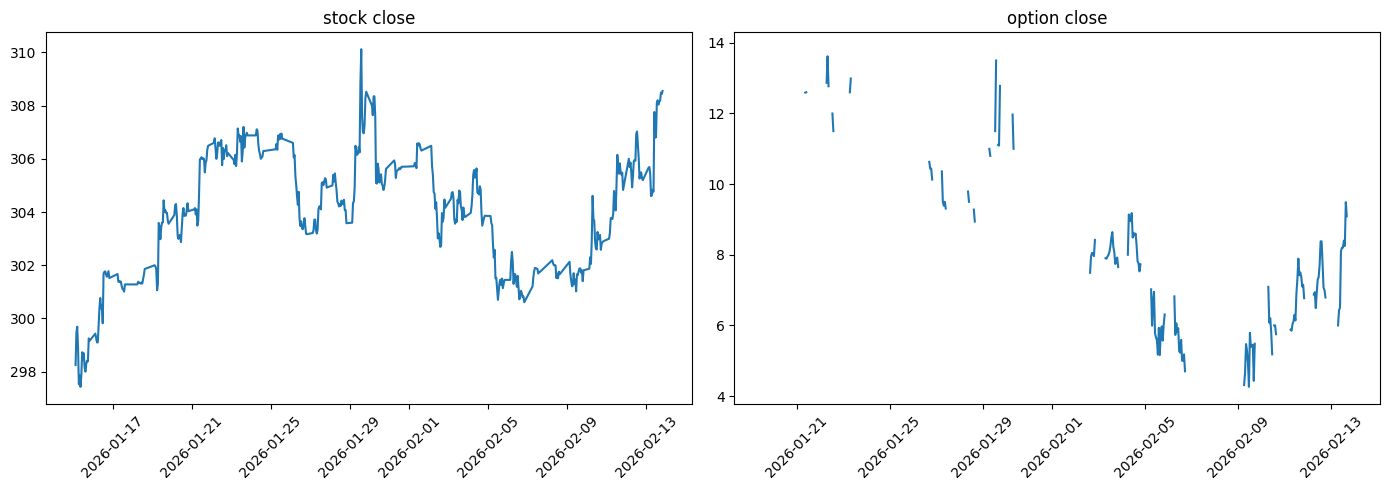

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(df.index, df['close_stock'])
ax1.set_title('stock close')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(df.index, df['close_option'])
ax2.set_title('option close')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()


In [18]:
from src.black_scholes import solve_black_scholes

df['BS_price'] = None
for index in df.index:
    
    strike_price = 300 
    vol = 0.2
    price = df['close_stock'][index]
    rf = 0.15
    
    fair_price = solve_black_scholes(price, strike_price, rf, vol, option_maturity_date, index)['price']
    df.loc[index, 'BS_price'] = fair_price

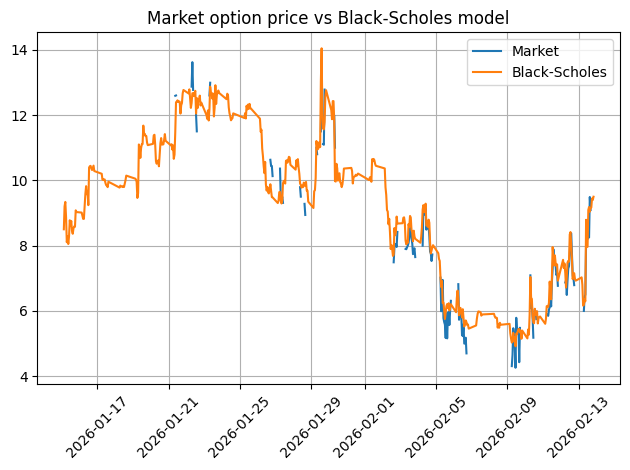

In [19]:
plt.plot(df.index, df['close_option'], label = "Market")
plt.plot(df.index, df['BS_price'], label="Black-Scholes")
plt.tick_params(axis='x', rotation=45)
plt.grid()
plt.legend()
plt.title("Market option price vs Black-Scholes model")
plt.tight_layout()
plt.show()